In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

gpytorch.functions.use_toeplitz = False
gpytorch.functions.max_cg_iterations = 100

%matplotlib inline

In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_x = train_x.cuda()
train_y = train_y.cuda()

In [3]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=256,
                                                            grid_bounds=[(0, 1)])
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)


likelihood = GaussianLikelihood().cuda()
model = GPRegressionModel(train_x.data, train_y.data, likelihood).cuda()

In [4]:
# Optimize the model
model.train()
likelihood.train()

optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0

def train():
    for i in range(20):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/20 - Loss: %.3f' % (i + 1, loss.data[0]))
        optimizer.step()
%time train()

Iter 1/20 - Loss: 1.139
Iter 2/20 - Loss: 1.079
Iter 3/20 - Loss: 1.027
Iter 4/20 - Loss: 0.981
Iter 5/20 - Loss: 0.946
Iter 6/20 - Loss: 0.921
Iter 7/20 - Loss: 0.910
Iter 8/20 - Loss: 0.897
Iter 9/20 - Loss: 0.873
Iter 10/20 - Loss: 0.841
Iter 11/20 - Loss: 0.789
Iter 12/20 - Loss: 0.723
Iter 13/20 - Loss: 0.629
Iter 14/20 - Loss: 0.519
Iter 15/20 - Loss: 0.400
Iter 16/20 - Loss: 0.278
Iter 17/20 - Loss: 0.168
Iter 18/20 - Loss: 0.068
Iter 19/20 - Loss: -0.011
Iter 20/20 - Loss: -0.073
CPU times: user 8.76 s, sys: 17.2 s, total: 25.9 s
Wall time: 27.2 s


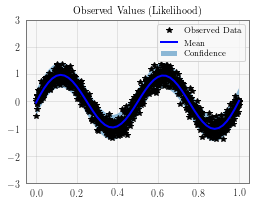

In [6]:
model.eval()
likelihood.eval()

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
test_x = Variable(torch.linspace(0, 1, 51)).cuda()
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))

def ax_plot(ax, rand_var, title):
    lower, upper = rand_var.confidence_region()
    ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
    ax.plot(test_x.data.cpu().numpy(), rand_var.mean().data.cpu().numpy(), 'b')
    ax.fill_between(test_x.data.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')